In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import lusee
from scipy.interpolate import interp1d
import scipy.signal as signal
from CalibSequencer import CalibSequencer
import healpy as hp

In [2]:
beam = lusee.Beam()
T=lusee.Throughput(beam)

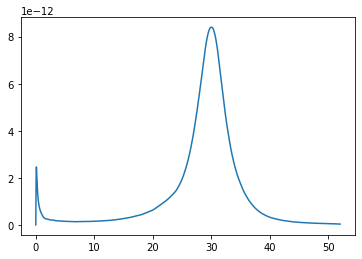

In [3]:
f=np.linspace(0.01,52,1000)
PkWhite = T.SG2V(f)*1e-22*1*T.power_gain(f,'M')
PkWhite[f<0.05]=0.0
fl=open('Pk_white-22.txt','w')
for f_,Pk_ in zip(f,PkWhite):
    fl.write("%g %g \n"%(f_,Pk_))
fl.close()
plt.plot(f,PkWhite)

In [4]:
I,Q,U,V = beam.power_stokes()
Lf = np.sqrt(Q**2+U**2)/I ## linear fraction
linear_gain = beam.gain * Lf

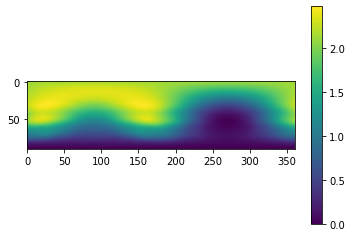

In [5]:
plt.imshow(linear_gain[20,:,:])
#plt.imshow(beam.gain[:,:,4])
plt.colorbar()

In [6]:
CS=CalibSequencer(seed=123)

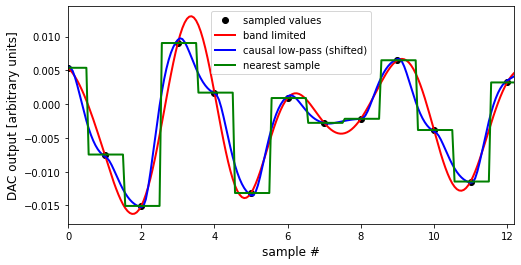

In [8]:
plt.figure(figsize=(8,4))
Np=200
x=np.arange(Np)/16
plt.plot(np.arange(Np/16),CS.sigo_band[0:Np:16],'ko',lw=2, label='sampled values')
plt.plot(x,CS.sigo_band[0:Np],'r-',lw=2, label="band limited")
plt.plot(x,CS.sigo_filt[:Np],'b-',lw=2, label= "causal low-pass (shifted)")
plt.plot(x,CS.sigo_step[0:Np],'g-',lw=2, label="nearest sample")
plt.xlabel('sample #',fontsize=12)
plt.ylabel('DAC output [arbitrary units]',fontsize=12)
plt.legend(fontsize=10)
plt.xlim(0,12.2)
plt.savefig('cal_samples.pdf',dpi=300)

In [318]:
CS.write_file('calib_band.txt',CS.sigo_band)
CS.write_file('calib_filt.txt',CS.sigo_filt)
CS.write_file('calib_step.txt',CS.sigo_step)

In [265]:
f=open('ladder_1024.txt','w')
for num in range(1024):
    f.write('%g\n'%num)
f.close()

In [319]:
Nside = 8
Npix = Nside**2*12
from tqdm import tqdm
maxi=0
maxr=0
for ipix in tqdm(range(Npix)):
    theta,phi = hp.pix2ang(Nside,ipix)
    theta *= 180/np.pi
    phi *= 180/np.pi
    
    if (theta<=90):
        CS=CalibSequencer(theta=theta, phi=phi, seed=123, Etheta=True)
        np.save(f'calib_hp{ipix}_t.beam',CS.beam_response[1::2])
        if (CS.beam_response.sum()>maxr):
            maxi = ipix
            maxr = CS.beam_response.sum()    
        CS.write_file(f'calib_hp{ipix}_t',CS.sigo_filt)
        CS=CalibSequencer(theta=theta, phi=phi, seed=123, Etheta=False) 
        np.save(f'calib_hp{ipix}_p.beam',CS.beam_response[1::2])
        CS.write_file(f'calib_hp{ipix}_p',CS.sigo_filt)
        #plt.plot(CS.beam_response)
        
        
        

100%|████████| 768/768 [00:59<00:00, 12.85it/s]


In [299]:
maxi

91